In [3]:
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from utils.experiments import *
from config import FIGURE_DIR
from config import TABLE_DIR

In [4]:
p = 1
res = []
for p in Path(f'results/rs_p={p}').glob('*'):
    a = load_pickle(p)
    res.append(a)

df = pd.DataFrame(res)
df = df[df.converged]
df =df[df.d>2]
df=df[df.p==1]
for (p, d), g in df.groupby(['p','d']):
    f = g.sort_values('mag_init')

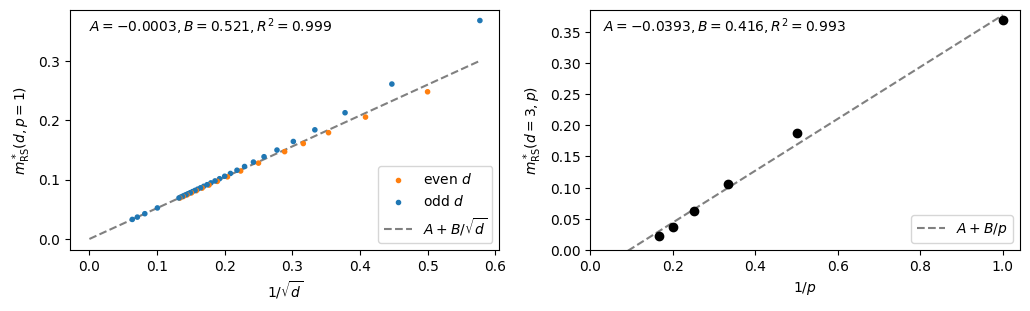

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

fig, axes = plt.subplots(1, 2, figsize=(2 * 5.2, 5.2/1.618))

ax = axes[0]  # switch target axes

xs, ys = [], []
all_results = []
for (p, d), g in df.groupby(['p','d']):
    f = g.sort_values('mag_init')
    x_tmp = f.mag_init
    y_tmp = f.entropy

    y_at_0 = np.interp(0, y_tmp, x_tmp)
    if (x_tmp < 0.0).sum() > 0:
        x_at_0 = np.interp(0, x_tmp, y_tmp)
    else:
        x_at_0 = np.nan

    all_results.append({'p': p, 'd': d, "m": y_at_0, "entropy": x_at_0})
    xs.append(d)
    ys.append(y_at_0)

xs = np.array(xs)
ys = np.array(ys)
ax.scatter([], [], c='tab:orange', label='even $d$',marker='.')
ax.scatter([], [], c='tab:blue', label='odd $d$',marker='.')

X = 1 / np.sqrt(xs)
Y = ys
colors = ['tab:orange' if v % 2 == 0 else 'tab:blue' for v in xs]

ax.scatter(X, Y, c=colors, marker='.')


mask = xs >= 40
X_fit = X[mask].reshape(-1,1)
Y_fit = Y[mask]

reg = LinearRegression().fit(X_fit, Y_fit)
a = reg.intercept_
b = reg.coef_[0]
r2 = reg.score(X_fit, Y_fit)

x_line = np.linspace(0, X.max(), 200).reshape(-1,1)
y_line = reg.predict(x_line)
ax.plot(x_line, y_line, linestyle='--', color='grey' , label=r'$A+B/\sqrt{d}$', zorder=-100)
ax.text(0, 0.35, f'$A={a:.4f}, B={b:.3f}, R^2={r2:.3f}$')
ax.legend()
ax.set_xlabel(r'$1/\sqrt{d}$')
ax.set_ylabel(r'$m_{\mathrm{RS}}^*(d,p=1)$')



ax = axes[1]

df = pd.read_csv('tables/rs.csv')
df = df[df.d==3]
df

x = 1 / df.p
y = df.m_min

# colors by parity of p
colors = ['tab:orange' if v % 2 == 0 else 'tab:blue' for v in df.p]

ax.scatter(x, y, c='black')

ax.set_xlabel('$1/p$')
ax.set_ylabel(r'$m_{\mathrm{RS}}^*(d=3,p)$')
ax.set_ylim(0)
ax.set_xlim(0)

# linear regression
X_fit = x.values.reshape(-1,1)
Y_fit = y.values
reg = LinearRegression().fit(X_fit, Y_fit)
a = reg.intercept_
b = reg.coef_[0]
r2 = reg.score(X_fit, Y_fit)

# fit line
x_line = np.linspace(0, x.max(), 200).reshape(-1,1)
y_line = reg.predict(x_line)

ax.plot(x_line, y_line, color='grey', linestyle='--', label=r'$A+B/p$', zorder=-100)
ax.text(0.03, 0.35,f'$A={a:.4f}, B={b:.3f}, R^2={r2:.3f}$')

ax.legend()
plt.tight_layout()
plt.savefig(FIGURE_DIR / 'BDCM-min_init-extrapolations.pdf', bbox_inches='tight')
